In [6]:
import PIL.Image as Image
# helper image to read image as rgb list
def read_image(path:str):
    im = Image.open(path)
    height, width = im.size
    pixels = list(im.getdata())
    print(len(pixels))
    return pixels, height, width

In [5]:
import numpy as np

def lms_daltonization(rgb:list):
    # RGB to LMS matrix
    dalt_matrix = [[0.0, 0.0, 0.0], [0.7, 1.0, 0.0], [0.7, 0.0, 1.0]]
    dalt_matrix = np.array(dalt_matrix)

    dalt_rgb = np.tensordot(rgb, dalt_matrix, axes=(-1, -1))
    
    return dalt_rgb

In [9]:
import numpy as np

# convert rgb to lms
def rgb2lms(rgb:list):
    rgb = np.array(rgb)
    rgb = rgb / 255
    lms_matrix = np.array([[17.8824, 43.5161, 4.11935], [3.45565, 27.1554, 3.86714], [0.0299566, 0.184309, 1.46709]])
    lms = np.dot(lms_matrix, rgb)
    return lms

# simulate dueteranopia
def simulate_dueteranopia(rgb:list):
    lms = rgb2lms(rgb)
    dueteranopia_matrix = np.array([[1, 0, 0], [0.49421, 0, 1.2483], [0, 0, 1]])
    lms = np.array(lms)
    lms = np.dot(dueteranopia_matrix, lms)
    inverse_lms_matrix = np.array([[0.080944, -0.130504, 0.116721], [-0.0102485, 0.0540194, -0.113615], [-0.000365294, -0.00412163, 0.693513]])
    rgb = np.dot(inverse_lms_matrix, lms)
    for i in range(len(rgb)):
        if rgb[i] < 0:
            rgb[i] = 0
        if rgb[i] > 1:
            rgb[i] = 1
    rgb = rgb * 255
    return rgb

In [2]:
from glob import glob
import numpy as np
import os
import cv2
import PIL.Image as Image

# dataset loader

def make_dataset(folder:str, num_images:int, size_x:int, size_y:int):
    img_list = glob(os.path.join(folder, '*.jpg'))
    images = img_list[:num_images]
    image_set = []
    for i in range(len(images)):
        image = cv2.imread(images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (size_x, size_y), interpolation=cv2.INTER_AREA)
        image = Image.fromarray(image)
        # crop image to 500 x 500
        #image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)
        image = image/255.0
        image_set.append(image)
    return image_set

def make_datasetn(folder:str, num_images:int):
    img_list = sorted(os.listdir(folder), key=lambda x: int(x.split('_')[1].split('.')[0]))
    images = img_list
    image_set = []
    for i in range(len(images)):
        image = cv2.imread(os.path.join(folder, images[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = np.array(image)
        image = image/255.0
        image_set.append(image)
    return image_set

In [3]:
files = make_datasetn('/Users/satyamgoyal/Downloads/EAAI 24 Research Paper/ColorblindCorrection/laboro_tomato/test_downsized', 150)

In [12]:
import PIL.Image as Image
from glob import glob
import numpy as np
import json

#code to daltonize the images from 0.2 to 1.0 duretanopia severity
for i in np.arange(0.2, 1.1, 0.1):
    # intensity
    intensity = round(i, 1)
    # get the matrix
    with open('linear_simulation_data.json', 'r') as f:
        data = json.load(f)
    # get the matrix
    matrices = data.get('data')
    matrix = []
    for i in range(len(matrices)):
        if matrices[i].get('severity') == intensity:
            matrix = matrices[i].get('matrices')[1]
            break
    matrix = np.array(matrix)
    size_x = 484
    size_y = 648
    dalt_images = []
    path = 'dalt_results/training_results_{}/'.format(intensity)
    if not os.path.exists(path):
        os.makedirs(path)
    # files list contains the images
    for i, file in enumerate(files):
        # simulate dueteranopia
        sim_rgb = np.tensordot(file, matrix, axes=(-1, -1))
        rgb_lost = file - sim_rgb
        # daltonize the image
        dalt_rgb = lms_daltonization(rgb_lost)
        new_rgb = file + dalt_rgb
        # clip the values
        new_rgb[new_rgb < 0] = 0
        new_rgb[new_rgb > 1] = 1
        new_rgb = new_rgb * 255
        copy_rgb = new_rgb.copy()
        # save the image
        sim_corrected_img = copy_rgb
        sim_corrected_img = np.tensordot(sim_corrected_img, matrix, axes=(-1, -1))
        # clip the values
        sim_corrected_img[sim_corrected_img < 0] = 0
        sim_corrected_img[sim_corrected_img > 255] = 255
        # save the image
        sim_corrected_img = np.ravel(sim_corrected_img)
        sim_corrected_img = Image.fromarray(sim_corrected_img.reshape(size_y,size_x, 3).astype('uint8'))
        sim_corrected_img.save('dalt_results/training_results_{}/sim_corrected_{}.png'.format(intensity, i))

In [7]:
import PIL.Image as Image
from glob import glob
import numpy as np
import json

intensity = 0.5
#code to daltonize the images for a particular severity
with open('linear_simulation_data.json', 'r') as f:
    data = json.load(f)
# get the matrix
matrices = data.get('data')
matrix = []
for i in range(len(matrices)):
    if matrices[i].get('severity') == intensity:
        matrix = matrices[i].get('matrices')[1]
        break
matrix = np.array(matrix)
size_x = 484
size_y = 648
dalt_images = []
path = 'dalt_results/training_results_{}/'.format(intensity)
if not os.path.exists(path):
    os.makedirs(path)
new_files = []
new_files.append(files[0])
new_files.append(files[5])
new_files.append(files[72])
for i, file in enumerate(new_files):
    sim_rgb = np.tensordot(file, matrix, axes=(-1, -1))
    rgb_lost = file - sim_rgb
    dalt_rgb = lms_daltonization(rgb_lost)
    new_rgb = file + dalt_rgb
    new_rgb[new_rgb < 0] = 0
    new_rgb[new_rgb > 1] = 1
    new_rgb = new_rgb * 255
    copy_rgb = new_rgb.copy()
    new_rgb = np.ravel(new_rgb)
    new_rgb = Image.fromarray(new_rgb.reshape(size_y, size_x, 3).astype('uint8'))
    new_rgb.save('dalt_results/qual_test/dalt_{}.png'.format(i))
    sim_corrected_img = copy_rgb
    sim_corrected_img = np.tensordot(sim_corrected_img, matrix, axes=(-1, -1))
    sim_corrected_img[sim_corrected_img < 0] = 0
    sim_corrected_img[sim_corrected_img > 255] = 255
    sim_corrected_img = np.ravel(sim_corrected_img)
    sim_corrected_img = Image.fromarray(sim_corrected_img.reshape(size_y,size_x, 3).astype('uint8'))
    sim_corrected_img.save('dalt_results/qual_test/sim_corrected_{}.png'.format(i))

In [13]:
# code to daltonize a single image
new_pixels = np.array(new_pixels)
print(new_pixels.shape)
new_pixels2 = np.ravel(new_pixels)
new_image = Image.fromarray(new_pixels2.reshape(width, height, 3).astype('uint8'))
new_image.save('laboro1_daltonization.png')

(762048, 3)


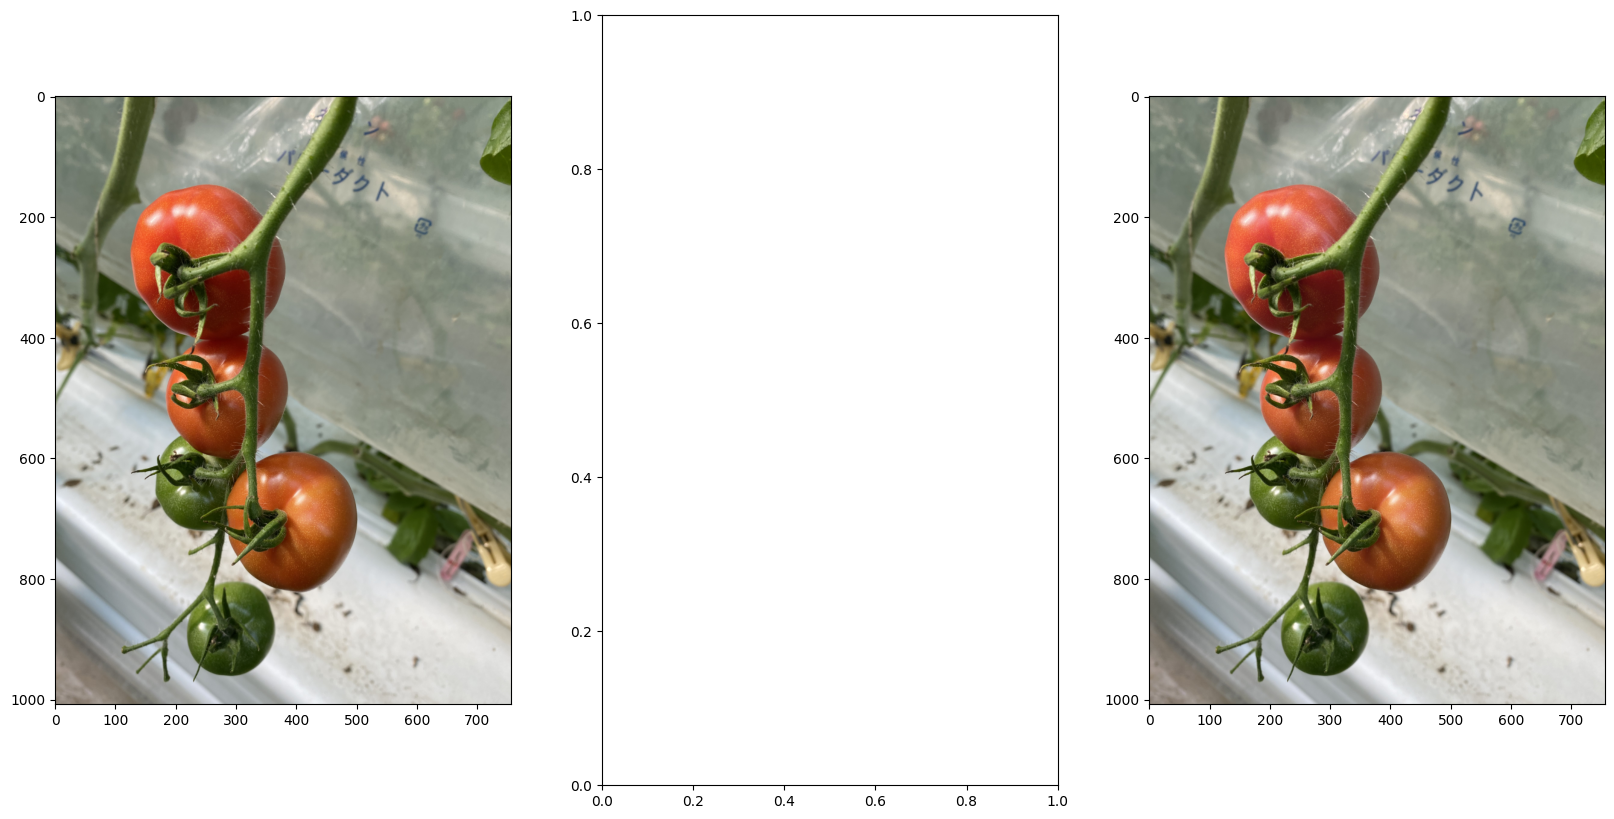

In [14]:
import PIL.Image as Image
import matplotlib.pyplot as plt

# plot the original image and the daltonized image
fig, axs = plt.subplots(1,3, figsize=(20, 10))
orignal = Image.open('/Users/satyamgoyal/Downloads/original_3.png')
axs[0].imshow(orignal)
# deuteranopia = Image.open('test5_dueteranopia.png')
# axs[1].imshow(deuteranopia)
new_image = Image.open('laboro1_daltonization.png')
axs[2].imshow(new_image)
